In [1]:
%run init_notebook.py

In [75]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,3)  #set default figure size
import numpy as np
from numba import vectorize, njit
from math import gamma
from scipy.integrate import quad

In [76]:
# Parameters in the two beta distributions.
F_a, F_b = 1, 1
G_a, G_b = 3, 1.2

@vectorize
def p(x, a, b):
    r = gamma(a + b) / (gamma(a) * gamma(b))
    return r * x** (a-1) * (1 - x) ** (b-1)

# The two density functions.
f = njit(lambda x: p(x, F_a, F_b))
g = njit(lambda x: p(x, G_a, G_b))

In [77]:
@njit
def simulate(a, b, T=50, N=500):
    '''
    Generate N sets of T observations of the likelihood ratio,
    return as N x T matrix.

    '''

    l_arr = np.empty((N, T))

    for i in range(N):

        for j in range(T):
            w = np.random.beta(a, b)
            l_arr[i, j] = f(w) / g(w)

    return l_arr

In [88]:
l_arr_g = simulate(G_a, G_b, T=100, N=500)
l_seq_g = np.cumprod(l_arr_g, axis=1)

In [89]:
l_arr_g.shape

(500, 100)

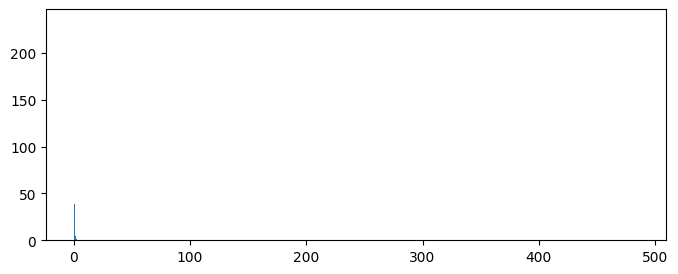

In [92]:
plt.hist(l_arr_g[:, 1], bins='fd');

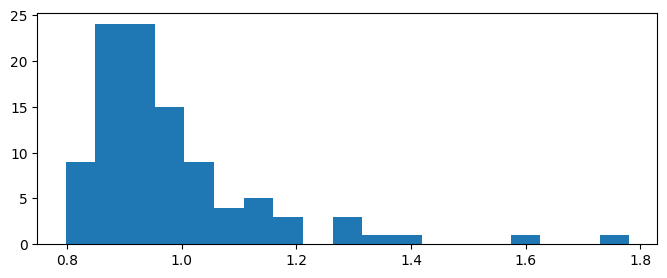

In [93]:
plt.hist(l_arr_g.mean(axis=0), bins='fd');

(0.0, 10.0)

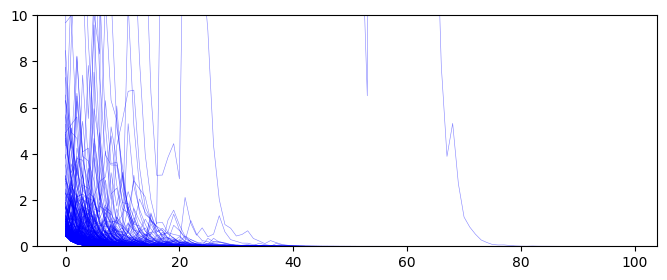

In [94]:
plt.plot(l_seq_g[:, :].T, lw=.4, color='blue', alpha=.5);
plt.ylim([0,10])

In [98]:
import scipy

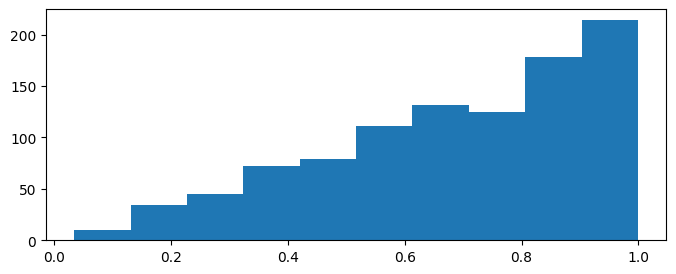

In [118]:
plt.hist(scipy.stats.beta(2,1).rvs(1000));

In [113]:
import scipy.optimize as op

In [121]:
@vectorize
def p(x, a, b):
    "The general beta distribution function."
    r = gamma(a + b) / (gamma(a) * gamma(b))
    return r * x ** (a-1) * (1 - x) ** (b-1)

def learning_example(F_a=2, F_b=1, G_a=3, G_b=1.2):
    """
    A wrapper function that displays the updating rule of belief π,
    given the parameters which specify F and G distributions.
    """

    f = njit(lambda x: p(x, F_a, F_b))
    g = njit(lambda x: p(x, G_a, G_b))

    # l(w) = f(w) / g(w)
    l = lambda w: f(w) / g(w)
    # objective function for solving l(w) = 1
    obj = lambda w: l(w) - 1

    x_grid = np.linspace(0, 1, 100)
    π_grid = np.linspace(1e-3, 1-1e-3, 100)

    w_max = 1
    w_grid = np.linspace(1e-12, w_max-1e-12, 100)

    # the mode of beta distribution
    # use this to divide w into two intervals for root finding
    G_mode = (G_a - 1) / (G_a + G_b - 2)
    roots = np.empty(2)
    roots[0] = op.root_scalar(obj, bracket=[1e-10, G_mode]).root
    roots[1] = op.root_scalar(obj, bracket=[G_mode, 1-1e-10]).root

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

    ax1.plot(l(w_grid), w_grid, label='$l$', lw=2)
    ax1.vlines(1., 0., 1., linestyle="--")
    ax1.hlines(roots, 0., 2., linestyle="--")
    ax1.set_xlim([0., 2.])
    ax1.legend(loc=4)
    ax1.set(xlabel='$l(w)=f(w)/g(w)$', ylabel='$w$')

    ax2.plot(f(x_grid), x_grid, label='$f$', lw=2)
    ax2.plot(g(x_grid), x_grid, label='$g$', lw=2)
    ax2.vlines(1., 0., 1., linestyle="--")
    ax2.hlines(roots, 0., 2., linestyle="--")
    ax2.legend(loc=4)
    ax2.set(xlabel='$f(w), g(w)$', ylabel='$w$')

    area1 = quad(f, 0, roots[0])[0]
    area2 = quad(g, roots[0], roots[1])[0]
    area3 = quad(f, roots[1], 1)[0]

    ax2.text((f(0) + f(roots[0])) / 4, roots[0] / 2, f"{area1: .3g}")
    ax2.fill_between([0, 1], 0, roots[0], color='blue', alpha=0.15)
    ax2.text(np.mean(g(roots)) / 2, np.mean(roots), f"{area2: .3g}")
    w_roots = np.linspace(roots[0], roots[1], 20)
    ax2.fill_betweenx(w_roots, 0, g(w_roots), color='orange', alpha=0.15)
    ax2.text((f(roots[1]) + f(1)) / 4, (roots[1] + 1) / 2, f"{area3: .3g}")
    ax2.fill_between([0, 1], roots[1], 1, color='blue', alpha=0.15)

    W = np.arange(0.01, 0.99, 0.08)
    Π = np.arange(0.01, 0.99, 0.08)

    ΔW = np.zeros((len(W), len(Π)))
    ΔΠ = np.empty((len(W), len(Π)))
    for i, w in enumerate(W):
        for j, π in enumerate(Π):
            lw = l(w)
            ΔΠ[i, j] = π * (lw / (π * lw + 1 - π) - 1)

    q = ax3.quiver(Π, W, ΔΠ, ΔW, scale=2, color='r', alpha=0.8)

    ax3.fill_between(π_grid, 0, roots[0], color='blue', alpha=0.15)
    ax3.fill_between(π_grid, roots[0], roots[1], color='green', alpha=0.15)
    ax3.fill_between(π_grid, roots[1], w_max, color='blue', alpha=0.15)
    ax3.hlines(roots, 0., 1., linestyle="--")
    ax3.set(xlabel='$\pi$', ylabel='$w$')
    ax3.grid()

    plt.show()

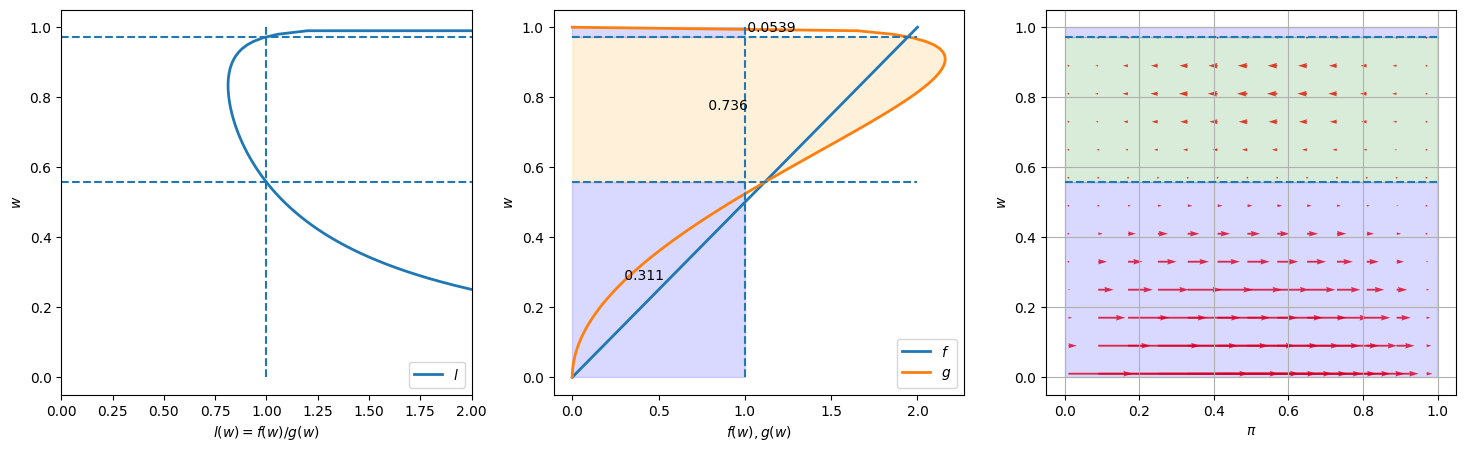

In [122]:
learning_example()